# Multiprocessing using Pools 
A simple framework for assessing the impact of multiprocessing on runtime on a multi-core machine. 

In [2]:
import time
import math
import multiprocessing
from multiprocessing import Pool
# using M1 Mac so initial code provided would not work
# get_context solution used from https://stackoverflow.com/questions/67999589/multiprocessing-with-pool-throws-error-on-m1-macbook
from multiprocessing import get_context

from PIL import Image, ImageFilter
import os
import sys
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

We have amended pool_process slightly from the one provided. As per the cell above we have used the get_context method, and in addition we are returning the time taken to allow us to chart the run times more easily.

In [3]:
# A function for timing a job that uses a pool of processes.
#  f is a function that takes a single argument
#  data is an array of arguments on which f will be mapped
#  pool_size is the number of processes in the pool.

def pool_process(f, data, pool_size):
    tp1 = time.time()
    pool = get_context("fork").Pool(processes=pool_size) # initialize the Pool.
    result = pool.map(f, data)       # map f to the data using the Pool of processes to do the work 
    pool.close() # No more processes
    pool.join()  # Wait for the pool processing to complete. 
    #print("Results", result)
    time_taken = round((time.time()-tp1),2)
    #print("Overall Time:", time_taken, "seconds")
    return time_taken
 

In [3]:
# This verbose version shows which process in the pool is running each task. 
def my_func_verbose(x):
    s = math.sqrt(x)
    print("Task: ", multiprocessing.current_process(), x, s)
    return s

In [4]:
dataRange = range(10)

Use the pool_process function to apply my_func to the data in dataRange.  
This task is so light it requires very little processing time. 

In [5]:
pool_process(my_func_verbose, dataRange, 2)

Task: Task:   <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon><ForkProcess name='ForkPoolWorker-1' parent=5232 started daemon>  02  1.41421356237309510.0

Task: Task:   <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon><ForkProcess name='ForkPoolWorker-1' parent=5232 started daemon>  31  1.73205080756887721.0

Task: Task:   <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon> <ForkProcess name='ForkPoolWorker-1' parent=5232 started daemon>4 6  2.0
2.449489742783178Task: 
 Task: <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon>  <ForkProcess name='ForkPoolWorker-1' parent=5232 started daemon>5 7  2.236067977499792.6457513110645907

Task:  <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon> 8 2.8284271247461903
Task:  <ForkProcess name='ForkPoolWorker-2' parent=5232 started daemon> 9 3.0


0.07

It is evident that the above functions are not complicated enough (i.e. they take very little time to execute) to warrant utilising extra cores. Therefore the naive prime checker below is introduced in order to quantify the speed-up from extra cores.

## A naive function for checking primes 

We note that we have not changed the check_prime function to be less naive as the ultimate goal in this assignment is to check the speed derived from using multiple cores, rather than actual efficiency.

<b>Note that when utilising the check_prime function we have used the capture magic method in order to hide the print statements and keep the output clean.</b>

In [6]:
def check_prime(num):
    t1 = time.time()
    res = False
    if num > 0:
        # check for factors
        for i in range(2,num):
            if (num % i) == 0:
                print(num,"is not a prime number")
                print(i,"times",num//i,"is",num)
                print("Time:", int(time.time()-t1))
                break
        else:
            print(num,"is a prime number")
            print("Time:", time.time()-t1) 
            res = True
            # if input number is less than
            # or equal to 1, it is not prime
    return res

In [7]:
%%capture
check_prime(7)

In [8]:
%%capture
check_prime(15488803)

# Part A

Using 8 digit primes which are sufficiently large enough to take Python a while to process. This is a factor of 8, the maximum number of cores we will utilise in our tests.

In [9]:
primes = [15484661,15484697,15484709,15484723,15484769,15484771,15484783,15484817,15484823,15484873,15484877,15484879,15484901,
         15484919,15484939,15484951,15484961,15484999,15485039,15485053,15485059,15485077,15485083,15485143,15485161,15485179,15485191,
         15485221,15485243,15485251,15485257,15485273,15485287,15485291,15485293,15485299]
print("Using a list of", len(primes), "primes for our tests.")

Using a list of 36 primes for our tests.


In the below cell we show that by testing each of the numbers in the primes list normally (i.e. without multiprocessing) the time taken for the list to be calculated is quite substantial (c. 30 seconds). In addition, this is close to the same time taken when one core is used in the multiprocessing function (showing that it doesn't first slow one core down to create gains with extra cores).

In [10]:
%%capture
tp1 = time.time()
for i in primes:
     check_prime(i)
time_taken = int(time.time()-tp1)

In [11]:
print("Overall Time:", time_taken, "seconds")

Overall Time: 30 seconds


timeFunc takes a list of numbers to check and passes that list to the pool_process function 8 times, first telling it to use 1 core, and each time increasing the number of cores by 1. It returns a list of times taken to process the list for each number of cores.

In [12]:
def timeFunc(numbers):
    times = []
    # loop through 8 cores
    for cores in range(1,9):
        times.append(pool_process(check_prime, numbers, cores))
        print('hello')
    return times

In [13]:
%%capture
running_time = timeFunc(primes)

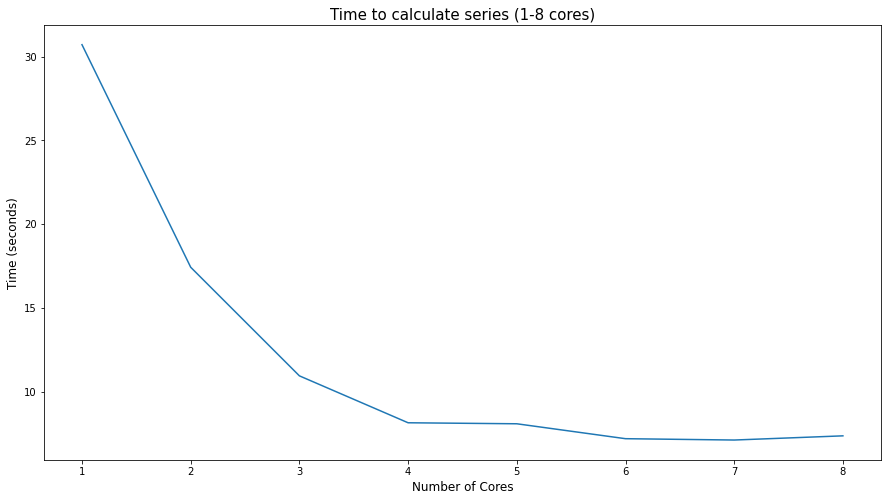

In [14]:
# list of the number of cores, used for plotting times
corenumbers = [x for x in range(1,9)]

plt.figure(figsize=(15,8))
plt.plot(corenumbers, running_time)
plt.xlabel("Number of Cores", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.title("Time to calculate series (1-8 cores)", fontsize=15)
plt.show()

It is quite evident that utilising extra cores decreases the overall running times. However, we also note that diminishing marginal returns set in as we add extra cores. Below is the same chart, but we have excluded the times for the first three cores.

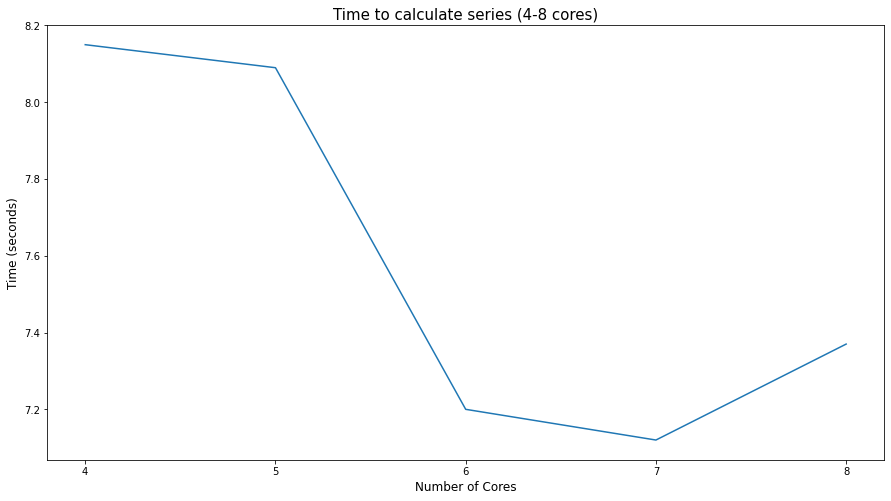

In [15]:
plt.figure(figsize=(15,8))
plt.plot(corenumbers[3:], running_time[3:])
plt.xlabel("Number of Cores", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
# below line sets axes to only actual recorded times
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Time to calculate series (4-8 cores)", fontsize=15)
plt.show()

From the above it is clear that increasing the number of cores being used is only beneficial to a point, at least in this experiment. After a certain point, the added benefit of an extra core is outweighed by the increased process management of instantiating extra Python interpreters (essentially what is happening when we add a core - see accompanying report for more detailed discussion of this point). Interestingly we do note a slight uptick for 8 cores, something that was not repeated every time we ran this experiment. This is likely due to external factors as well as the increased process management associated with the 8th additional core. Below we run further tests, with one aim being to check if this is repeated.

In [16]:
print("Run-time on 1 core:", running_time[0], "seconds")
print("Run-time on 2 core:", running_time[1], "seconds")
print("Run-time on 3 core:", running_time[2], "seconds")
print("Run-time on 4 core:", running_time[3], "seconds")
print("Run-time on 5 core:", running_time[4], "seconds")
print("Run-time on 6 core:", running_time[5], "seconds")
print("Run-time on 7 core:", running_time[6], "seconds")
print("Run-time on 8 core:", running_time[7], "seconds")
print("\nTime savings using 8 cores instead of 1: " + str(round(100*(1-running_time[7]/running_time[0]),2))+"%")
print("Time savings using 4 cores instead of 1: " + str(round(100*(1-running_time[3]/running_time[0]),2))+"%")
print("Time savings using 3 cores instead of 1: " + str(round(100*(1-running_time[2]/running_time[0]),2))+"%")
print("Time savings using 2 cores instead of 1: " + str(round(100*(1-running_time[1]/running_time[0]),2))+"%")

Run-time on 1 core: 30.71 seconds
Run-time on 2 core: 17.43 seconds
Run-time on 3 core: 10.95 seconds
Run-time on 4 core: 8.15 seconds
Run-time on 5 core: 8.09 seconds
Run-time on 6 core: 7.2 seconds
Run-time on 7 core: 7.12 seconds
Run-time on 8 core: 7.37 seconds

Time savings using 8 cores instead of 1: 76.0%
Time savings using 4 cores instead of 1: 73.46%
Time savings using 3 cores instead of 1: 64.34%
Time savings using 2 cores instead of 1: 43.24%


Next we generate arrays of increasing sizes (multiples of 8), all of which are derived from the primes list. These lists are then passed through timeFunc which as normal returns a list of 8 times corresponding to the times taken to calculate the list that was passed for each of the 8 cores. These times are then added to the running_time array in their respective positions, meaning that running_time_arrays is an array containing the cumulative times taken to run each of the arrays at varying numbers of cores. This is similar to looking at an average run time for each core (although we keep the cumulative time). Further, we run this 5 times to get a smoother chart, removing the impacts of outliers caused by external factors on the machine.

<b>N.B. below cell takes quite a bit of time to run.<b>

In [17]:
%%capture
# create list of 8 0's to add running time to
running_time_arrays = [0 for x in range(1,9)]

# repeat 5 times to get a smoother chart
for i in range(5):
    # create lists of increasing lengths of the primes
    for j in range(0,(len(primes)-7),8):
        prime_checks = primes[:(j+8)]
        times = timeFunc(prime_checks)
        # add to respective position in running_time list
        for k in range(len(times)):
            running_time_arrays[k] += times[k]

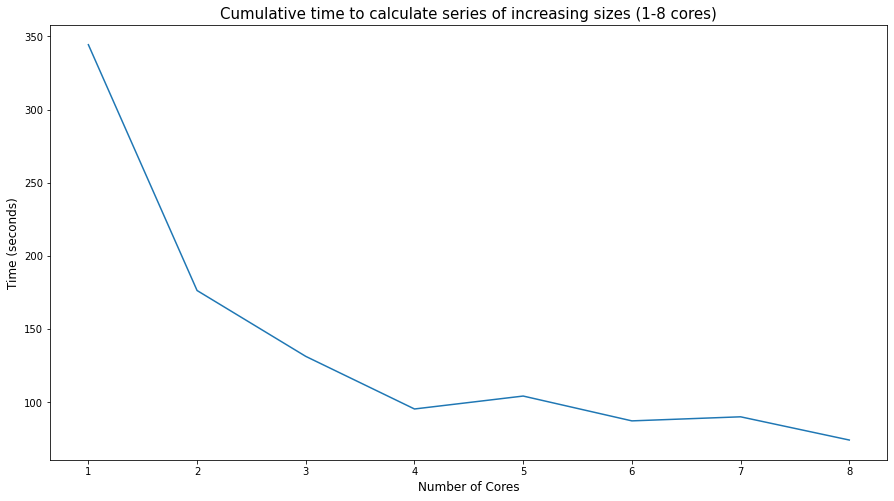

In [18]:
plt.figure(figsize=(15,8))
plt.plot(corenumbers, running_time_arrays)
plt.xlabel("Number of Cores", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.title("Cumulative time to calculate series of increasing sizes (1-8 cores)", fontsize=15)
plt.show()

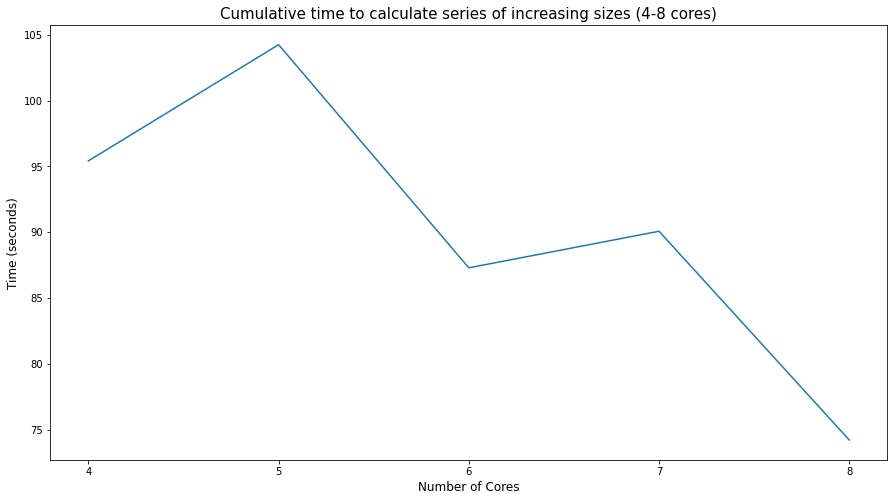

In [19]:
plt.figure(figsize=(15,8))
plt.plot(corenumbers[3:], running_time_arrays[3:])
plt.xlabel("Number of Cores", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
# below line sets axes to only actual recorded times
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Cumulative time to calculate series of increasing sizes (4-8 cores)", fontsize=15)
plt.show()

In [29]:
print("Run-time on 1 core:", round(running_time_arrays[0],2), "seconds")
print("Run-time on 2 core:", round(running_time_arrays[1],2), "seconds")
print("Run-time on 3 core:", round(running_time_arrays[2],2), "seconds")
print("Run-time on 4 core:", round(running_time_arrays[3],2), "seconds")
print("Run-time on 5 core:", round(running_time_arrays[4],2), "seconds")
print("Run-time on 6 core:", round(running_time_arrays[5],2), "seconds")
print("Run-time on 7 core:", round(running_time_arrays[6],2), "seconds")
print("Run-time on 8 core:", round(running_time_arrays[7],2), "seconds")
print("\nTime savings using 8 cores instead of 1: " + str(round(100*(1-running_time_arrays[7]/running_time_arrays[0]),2))+"%")
print("Time savings using 4 cores instead of 1: " + str(round(100*(1-running_time_arrays[3]/running_time_arrays[0]),2))+"%")
print("Time savings using 3 cores instead of 1: " + str(round(100*(1-running_time_arrays[2]/running_time_arrays[0]),2))+"%")
print("Time savings using 2 cores instead of 1: " + str(round(100*(1-running_time_arrays[1]/running_time_arrays[0]),2))+"%")

Run-time on 1 core: 344.33 seconds
Run-time on 2 core: 176.36 seconds
Run-time on 3 core: 131.36 seconds
Run-time on 4 core: 95.42 seconds
Run-time on 5 core: 104.25 seconds
Run-time on 6 core: 87.29 seconds
Run-time on 7 core: 90.07 seconds
Run-time on 8 core: 74.2 seconds

Time savings using 8 cores instead of 1: 78.45%
Time savings using 4 cores instead of 1: 72.29%
Time savings using 3 cores instead of 1: 61.85%
Time savings using 2 cores instead of 1: 48.78%


Once we again we observe significant gains from using multiple cores initially, with drop offs as the number gets higher. The percentage savings here are likely closer to the true savings than in the previous experiment, given that we have a smoother set of times. It is very interesting to observer that using one extra core close to halves the amount of time it takes to run the calculation, showing both how CPU bound the task is, as well as the benefits of overriding the restrictions placed on Python by the GIL, and the benefits of overriding them.

# Task 2.a

In [30]:
# Thumbnail size of processed images
size = (1200, 1200)

# List of images to process
image_names = [
    'image1-unsplash.jpg',
    'image2-unsplash.jpg',
    'image3-unsplash.jpg',
    'image4-unsplash.jpg',
    'image5-unsplash.jpg',
    'image6-unsplash.jpg',
    'image7-unsplash.jpg',
    'image8-unsplash.jpg',
    'image9-unsplash.jpg',
    'image10-unsplash.jpg',
    'image11-unsplash.jpg',
    'image12-unsplash.jpg',
    'image13-unsplash.jpg',
    'image14-unsplash.jpg',
    'image15-unsplash.jpg',
]

# Function that removes images from the folder to enable testing
#  multiple cores without having to manually delete images first
def remove_images(directory_name):
    for file in os.listdir(directory_name):
        os.remove(os.path.join(directory_name, file))

### Image Process Function

In [34]:
def process_image(image_name):
    image_to_process = Image.open(f'images/original/{image_name}')
    image_to_process = image_to_process.filter(ImageFilter.GaussianBlur(20))
    image_to_process.thumbnail(size)
    image_to_process.save(f'images/processed/{image_name}')

### Loop that calulates the running time to process the images using different numbers of cores
- N.B Function takes time to complete

In [35]:
processing_times = []
for i in range(1,9):
    tp1 = time.time()
    pool_process(process_image, image_names, i)
    time_taken = round((time.time()-tp1),2)
    processing_times.append(time_taken)
    remove_images('images/processed')
    if i == 1:
        core_word = "core"
        space = " "
    else:
        core_word = "cores"
        space = ""
    print("Time taken to process images using " + str(i) + " " + core_word + ": " + space + "\033[1m" + str(time_taken) + " seconds"+ "\033[0m")
print("\033[1m" + "All processing complete" + "\033[0m")

print("\nTime savings using 8 cores instead of 1: " + "\033[1m" +  str(round(100*(1-processing_times[7]/processing_times[0]),2))+"%" + "\033[0m")
print("Time savings using 4 cores instead of 1: " + "\033[1m" +  str(round(100*(1-processing_times[3]/processing_times[0]),2))+"%" + "\033[0m")
print("Time savings using 3 cores instead of 1: " + "\033[1m" +  str(round(100*(1-processing_times[2]/processing_times[0]),2))+"%" + "\033[0m")
print("Time savings using 2 cores instead of 1: " + "\033[1m" +  str(round(100*(1-processing_times[1]/processing_times[0]),2))+"%" + "\033[0m")

Time taken to process images using 1 core:  18.1 seconds
Time taken to process images using 2 cores: 10.71 seconds
Time taken to process images using 3 cores: 8.43 seconds
Time taken to process images using 4 cores: 7.42 seconds
Time taken to process images using 5 cores: 7.16 seconds
Time taken to process images using 6 cores: 6.62 seconds
Time taken to process images using 7 cores: 6.1 seconds
Time taken to process images using 8 cores: 6.61 seconds
All processing complete

Time savings using 8 cores instead of 1: 63.48%
Time savings using 4 cores instead of 1: 59.01%
Time savings using 3 cores instead of 1: 53.43%
Time savings using 2 cores instead of 1: 40.83%


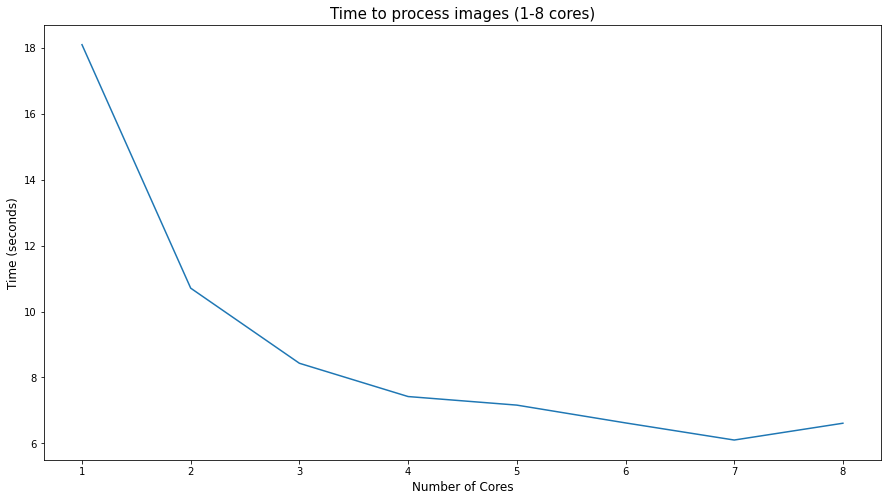

In [36]:
# list of the number of cores, used for plotting times
core_numbers = [x for x in range(1,9)]

plt.figure(figsize=(15,8))
plt.plot(core_numbers, processing_times)
plt.xlabel("Number of Cores", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.title("Time to process images (1-8 cores)", fontsize=15)
plt.show()

Similar to Part A we saw a large decreases in processing time from using multiple cores initially, but those gains diminished for later cores. We also noticed that increasing from 1 to 2 cores, led to a decrease in processing time of nearly 50% indicating that image processing is primarily a CPU bound task and that significant gains can be made by overriding the restrictions placed on Python by the GIL.